# A Python tutorial on validating gVirtualXRay:
## Analytic simulation vs. Monte Carlo simulation
### With a realistic phantom
#### Authors: F. P. Vidal and J. M. Létang

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to images generated with the state-of-the-art Monte Caro simulation packages. We take into account i) a realistic beam spectrum and ii) the energy response of the detector.

**Material and Methods:** We simulate an image with gVirtualXRay and compare it with a ground truth image. For this purpose, we use [Gate](http://www.opengatecollaboration.org/), a wrapper for CERN's state-of-the-art Monte Caro simulation tool: [Geant4](https://geant4.web.cern.ch/).

In our simulation the source-to-object distance (SOD) is 955mm, and the source-to-detector distance (SDD) is 1250mm. The beam spectrum is polychromatic and the energy response of the detector is considered.

![Geometric parameters](plots/pediatric_model.png)

The sample is a paediatric phantom from the [ERROR project](https://error.upatras.gr/) available from [https://drive.uca.fr/f/384a08b5f73244cf9ead/?dl=1](https://drive.uca.fr/f/384a08b5f73244cf9ead/?dl=1). We use the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/).
![Sample composition](plots/pediatric_model.png)

**Results:** The [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), between the two simulated images is **MAPE 3.43%**. The **[zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) is 99.99%**. 
The **[Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) is 0.99**. 
As MAPE is relatively low (less than 5%), SSIM is high (close to 1), and ZNCC is high (close to 100%), we can conclude that X-ray images simulated with gVirtualXRay on GPU in milliseconds are comparable to Monte Carlo simulations that ran on supercomputers for days.

## Import packages

In [1]:
%matplotlib inline

import base64

import os # Locate files

import urllib # Download and save the phantom
import zipfile # Unzip the file

import math
import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import matplotlib
# old_backend =  matplotlib.get_backend() 
# matplotlib.use("Agg")  # Prevent showing stuff

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
import matplotlib.colors as mcolors
import k3d

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

from scipy.stats import pearsonr # Compute the correlatio coefficient

import SimpleITK as sitk

from skimage.util import compare_images # Checkboard comparison between two images
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error as mape
from skimage.transform import resize # Resample the images

from tifffile import imread, imsave # Load/Write TIFF files

from stl import mesh
import random


# import pyvista as pv # 3D visualisation
# from pyvista import themes

# import cma # Optimise the parameters of the noise model

from sitk2vtk import sitk2vtk

import gvxrPython3 as gvxr # Simulate X-ray images

import json2gvxr # Set gVirtualXRay and the simulation up
from utils import * # Code shared across more than one notebook

SimpleGVXR 1.0.1 (2021-11-01T10:36:47) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-11-01T10:36:47) [Compiler: GNU g++] on Linux


## Reference image

We first load the reference image that has been simulated using [Gate](http://www.opengatecollaboration.org/) wrapper for CERN's [Geant4](https://geant4.web.cern.ch/). Here we ignore scattering.

In [2]:
Image = imread("pediatric_phantom_data/direct.tif")
Full_field = np.ones(Image.shape) # Perfect full field image
Dark_field = np.zeros(Full_field.shape) # Perfect dark field image

Projections are then corrected to account for variations in beam homogeneity and in the pixel-to-pixel sensitivity of the detector. This is the projection with flat-field correction ($\mathbf{Proj}$):
\begin{equation}
\mathbf{Proj} = \frac{\boldsymbol{I} - \boldsymbol{D}}{\boldsymbol{F} - \boldsymbol{D}}
\label{eq:flat-fields}
\end{equation}
where $\boldsymbol{F}$ (full fields) and $\boldsymbol{D}$ (dark fields) are projection images without sample and acquired with and without the X-ray beam turned on respectively. 
<!-- Note that with an ideal detector ($\boldsymbol{R}_i=E_i$), pixels of $\boldsymbol{D}$ are null, and pixels of $\boldsymbol{F}$ are equal to $\sum_i E_i \; \boldsymbol{N}_i$. 
 -->

We now apply the flat-field correction to `Image`.

In [3]:
gate_image = (Image - Dark_field) / (Full_field - Dark_field)
imsave("gVirtualXRay_output_data/pediatric_direct_flat.tif", gate_image.astype(np.single))

We plot the image using a linear look-up table and a log normalisation.

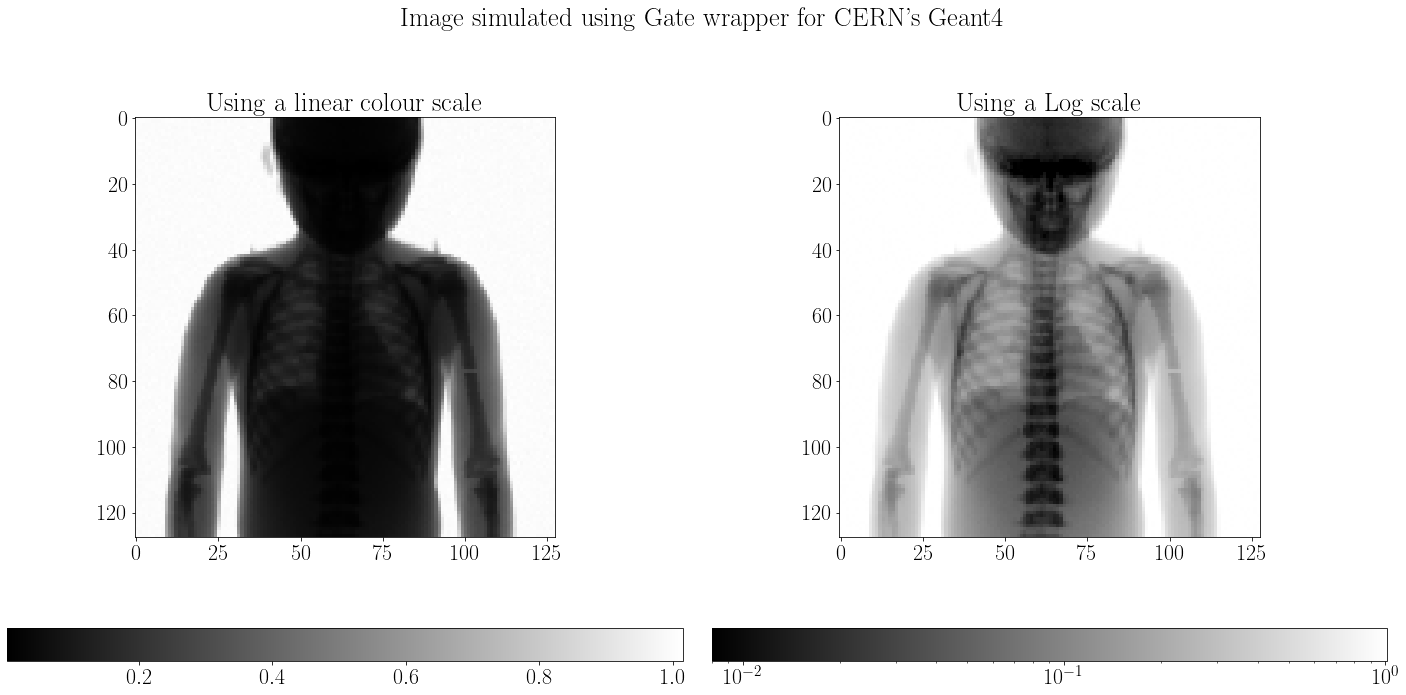

In [4]:
vmin=0.008
vmax=gate_image.max() * 1
displayLinearPowerScales(gate_image,
                         "Image simulated using Gate wrapper for CERN's Geant4",
                         "plots/pediatric_phantom",
                         True, vmin, vmax)

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [5]:
json2gvxr.initGVXR("notebook-6.json", "OPENGL")

Create an OpenGL context: 800x450
gvxrStatus:	Create window 0
gvxrStatus:	Create window 
0 0 500 500
OpenGL renderer:   NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 470.42.01
OpenGL vender:     NVIDIA Corporation
Use OpenGL 4.5.
0 0 800 450


## X-ray source

We create an X-ray source. It is a point source.

In [6]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0.0, 1000.0, 0.0, 'mm']
	Source shape: PointSource


## Spectrum

The spectrum is polychromatic.

In [7]:
spectrum, unit, k, f = json2gvxr.initSpectrum(verbose=0)
energy_set = sorted(spectrum.keys())

count_set = []

for energy in energy_set:
    count_set.append(spectrum[energy])

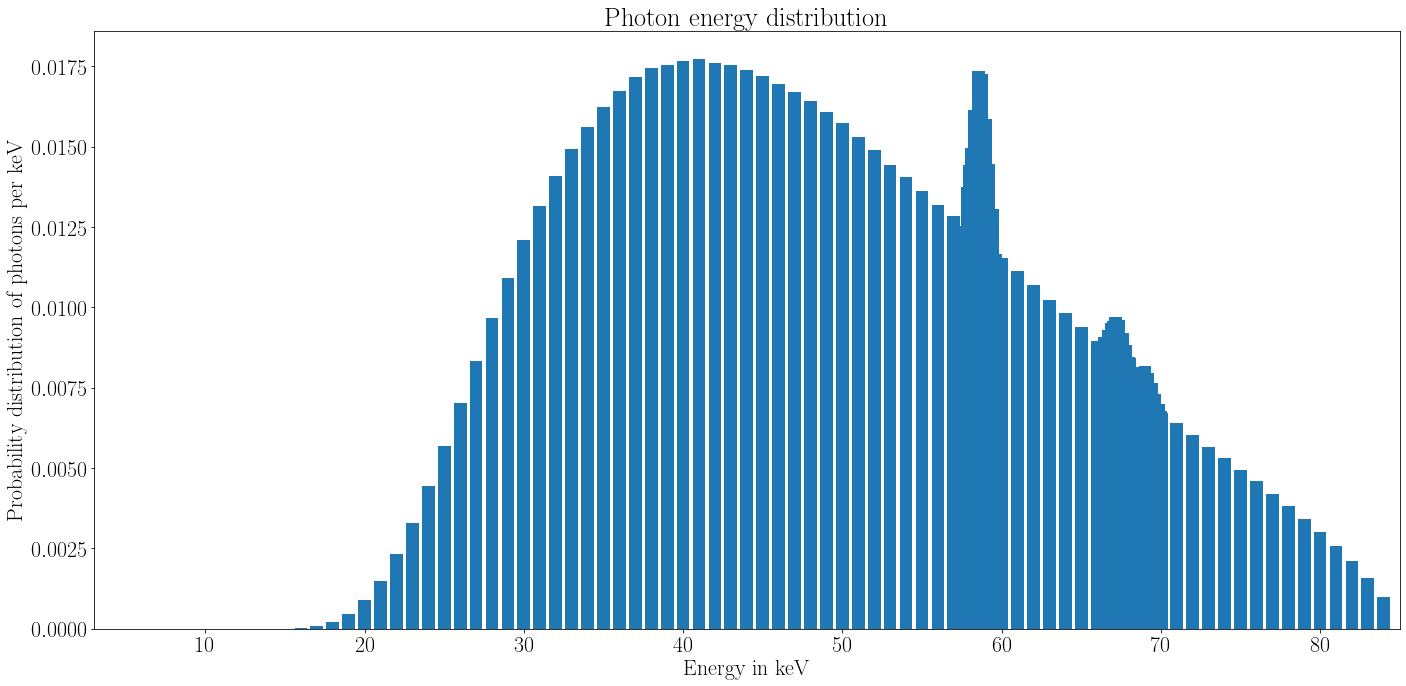

In [8]:
k *= 1000
plotSpectrum(k, f, "plots/pediatric_spectrum", xlim=[np.min(k), np.max(k)])

## Detector

Create a digital detector

In [9]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0.0, -150.0, 0.0, 'mm']
	Detector up vector: [0, 0, -1]
	Detector number of pixels: [1152, 1152]
	Energy response: Gate_data/responseDetector.txt in MeV
	Pixel spacing: [0.4340277777777778, 0.4340277777777778, 'mm']
INIT RENDER


## Model the energy response of the detector

Load the energy response

In [10]:
detector_response = np.loadtxt("Gate_data/responseDetector.txt")

Display the energy response

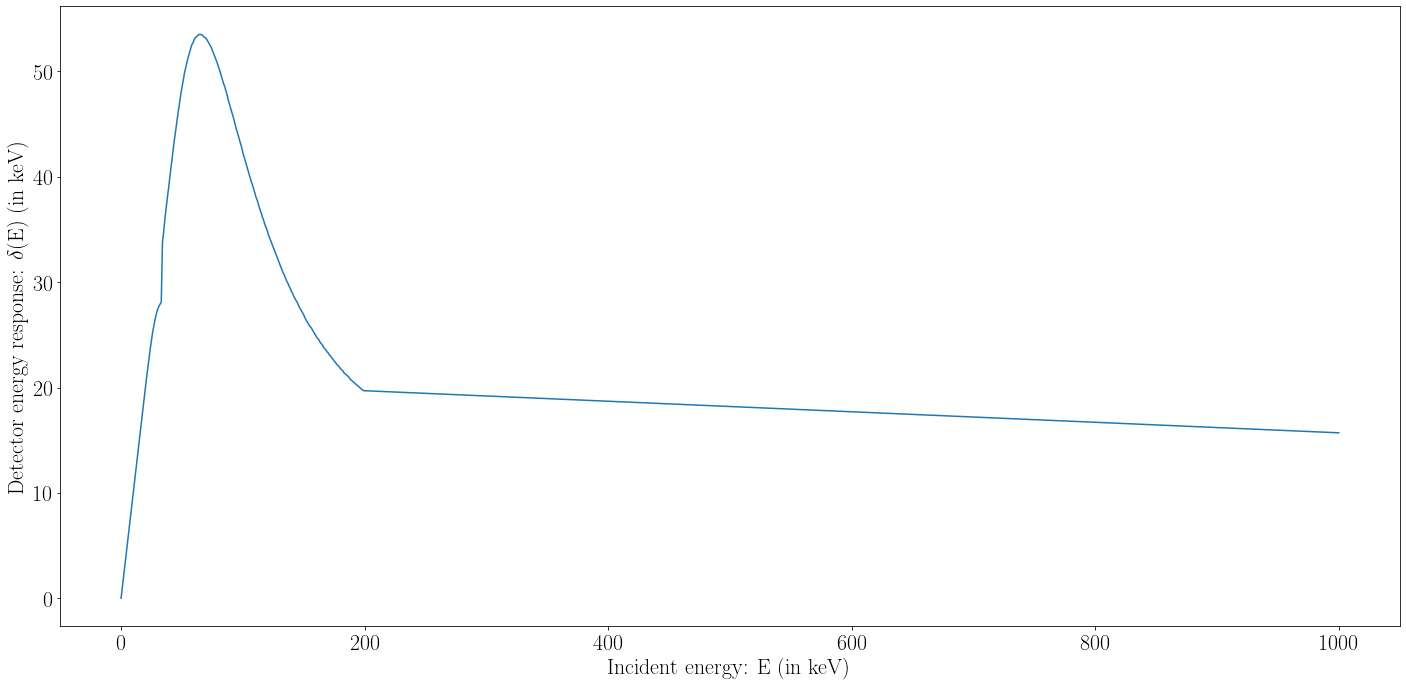

In [11]:
plt.figure(figsize= (20,10))
# plt.title("Detector response")
plt.plot(detector_response[:,0] * 1000, detector_response[:,1] * 1000)
plt.xlabel('Incident energy: E (in keV)')
plt.ylabel('Detector energy response: $\\delta$(E) (in keV)')

plt.tight_layout()

## Sample

Download and unzip the phantom

In [12]:
if not os.path.exists("pediatric_phantom_data/Pediatric phantom.zip"):
    urllib.request.urlretrieve("https://drive.uca.fr/f/384a08b5f73244cf9ead/?dl=1", "pediatric_phantom_data/Pediatric phantom.zip")

    with zipfile.ZipFile("pediatric_phantom_data/Pediatric phantom.zip","r") as zip_ref:
        zip_ref.extractall("pediatric_phantom_data")

Load the phantom

In [13]:
phantom = sitk.ReadImage("pediatric_phantom_data/Pediatric phantom/Pediatric_model.mhd")

Load the labels

In [14]:
df = pd.read_csv("pediatric_phantom_data/labels.dat")

Process every structure of the phantom

In [15]:
if not os.path.exists("pediatric_phantom_data/meshes"):
    os.mkdir("pediatric_phantom_data/meshes")

if not os.path.exists("pediatric_phantom_data/segmentations"):
    os.mkdir("pediatric_phantom_data/segmentations")

meshes = []

for threshold, organ in zip(df["Label"], df["Organs"]):

    # Ignore air
    if organ != "Air":

        print("Process", organ)
        
        seg_fname = "pediatric_phantom_data/segmentations/" + organ + ".mha"
        mesh_fname = "pediatric_phantom_data/meshes/" + organ + ".stl"
        meshes.append(mesh_fname)

        # Only create the mesh if it does not exist
        if not os.path.exists(mesh_fname):
            
            # Only segment the image it is not done as yet
            if not os.path.exists(seg_fname):
            
                # Threshold the phantom
                binary_image = (phantom == threshold)

                # Smooth the binary segmentation
                smoothed_binary_image = sitk.AntiAliasBinary(binary_image)

                sitk.WriteImage(smoothed_binary_image, seg_fname)
            else:
                smoothed_binary_image = sitk.ReadImage(seg_fname)
                            
            # Create a VTK image
            vtkimg = sitk2vtk(smoothed_binary_image, centre=True)

            mesh = extractSurface(vtkimg, 0)
            
#             print('Before decimation')
#             print(f'There are {mesh.GetNumberOfPoints()} points.')
#             print(f'There are {mesh.GetNumberOfPolys()} polygons.')

#             decimate = vtk.vtkDecimatePro()
#             decimate.SetInputData(mesh)
#             decimate.SplittingOn()
#             decimate.SetTargetReduction(30)
#             decimate.PreserveTopologyOn()
#             decimate.Update()

#             decimated = vtk.vtkPolyData()
#             decimated.ShallowCopy(decimate.GetOutput())

#             print('After decimation')
#             print(f'There are {decimated.GetNumberOfPoints()} points.')
#             print(f'There are {decimated.GetNumberOfPolys()} polygons.')
#             print(
#                 f'Reduction: {(mesh.GetNumberOfPolys() - decimated.GetNumberOfPolys()) / mesh.GetNumberOfPolys()}')
            
#             print("\n\n")
#             writeSTL(decimated, mesh_fname)
            writeSTL(mesh, mesh_fname)


Process Muscle
Process Bone
Process Stomach-Interior
Process Cartilage
Process Brain
Process Bladder
Process Gallbladder
Process Heart
Process Kidneys-right
Process Kidneys-left
Process Small-Intestine
Process Large-Intestine
Process Liver
Process Lung-right
Process Lung-left
Process Pancreas
Process Spleen
Process Stomach
Process Thymus
Process Eyes-right
Process Eyes-left
Process Skull
Process Trachea


In [16]:
json2gvxr.initSamples(verbose=0)

file_name:	pediatric_phantom_data/meshes/Muscle.stl	nb_faces:	1756726	nb_vertices:	5270178	bounding_box (in cm):	(-17.9687, -10.8887, -30.9017)	(16.6016, 11.1799, 28.6986)
file_name:	pediatric_phantom_data/meshes/Bone.stl	nb_faces:	541826	nb_vertices:	1625478	bounding_box (in cm):	(-16.7969, -23.6577, -30.9017)	(15.2152, 9.88865, 16.3501)
file_name:	pediatric_phantom_data/meshes/Stomach-Interior.stl	nb_faces:	9452	nb_vertices:	28356	bounding_box (in cm):	(-1.34334, -2.38867, -17.0041)	(4.16143, 3.05231, -8.50205)
file_name:	pediatric_phantom_data/meshes/Cartilage.stl	nb_faces:	163322	nb_vertices:	489966	bounding_box (in cm):	(-16.7615, -4.32288, -30.9017)	(15.5041, 8.717, 16.6771)
file_name:	pediatric_phantom_data/meshes/Brain.stl	nb_faces:	124028	nb_vertices:	372084	bounding_box (in cm):	(-7.32082, -9.98695, 16.3501)	(7.50031, 5.78681, 28.1222)
file_name:	pediatric_phantom_data/meshes/Bladder.stl	nb_faces:	3712	nb_vertices:	11136	bounding_box (in cm):	(-3.78536, 2.11808, -30.9017)	(0.

## Runing the simulation

Update the 3D visualisation and take a screenshot

In [17]:
gvxr.displayScene()

gvxr.computeXRayImage()
gvxr.useLighing()
gvxr.useWireframe()
gvxr.setZoom(1549.6787109375)
gvxr.setSceneRotationMatrix([-0.19267332553863525, -0.06089369207620621, 0.9793692827224731,  0.0,
                              0.9809651970863342,  -0.03645244985818863, 0.19072122871875763, 0.0,
                              0.02408679760992527,  0.9974713325500488,  0.06675821542739868, 0.0, 
                              0.0,                  0.0,                 0.0,                 1.0])

gvxr.displayScene()

0 0 500 500
0 0 800 450


In [18]:
print(gvxr.getZoom())
print(gvxr.getSceneRotationMatrix())


1549.6787109375
(-0.19267332553863525, -0.06089369207620621, 0.9793692827224731, 0.0, 0.9809651970863342, -0.03645244985818863, 0.19072122871875763, 0.0, 0.02408679760992527, 0.9974713325500488, 0.06675821542739868, 0.0, 0.0, 0.0, 0.0, 1.0)


In [19]:
screenshot = gvxr.takeScreenshot()

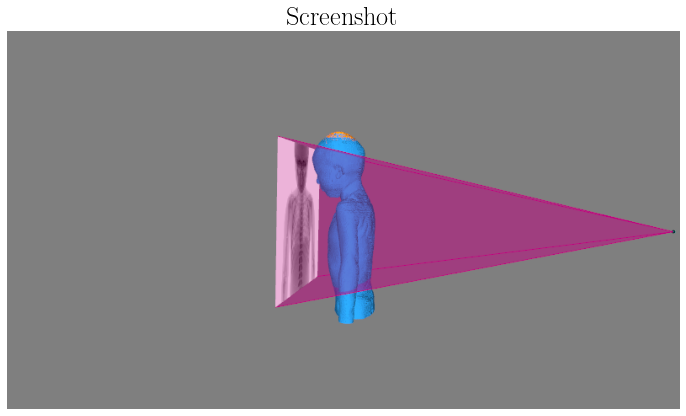

In [20]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/pediatric_screenshot-beam-off-detResponse.pdf')
plt.savefig('plots/pediatric_screenshot-beam-off-detResponse.png')

Compute an X-ray image

In [21]:
gvxr.enableArtefactFilteringOnCPU()
# gvxr.enableArtefactFilteringOnGPU()
# gvxr.disableArtefactFiltering() # Spere inserts are missing with GPU integration when a outer surface is used for the matrix

# Compute the L-buffers on the GPU and integrate on the CPU
x_ray_image_integration_CPU = computeXRayImageFromLBuffers(json2gvxr, True, detector_response, prefix="gVirtualXRay_output_data/pediatric_")
# x_ray_image_integration_CPU = np.flip(x_ray_image_integration_CPU, 1)
imsave('gVirtualXRay_output_data/pediatric_projection_raw_integration_CPU_detResponseE.tif', x_ray_image_integration_CPU.astype(np.single))

# Compute the L-buffers on the GPU and integrate on the GPU
x_ray_image_integration_GPU = np.array(gvxr.computeXRayImage())
# x_ray_image_integration_GPU = np.flip(x_ray_image_integration_GPU, 1)
imsave('gVirtualXRay_output_data/pediatric_projection_raw_integration_GPU_detResponseE.tif', x_ray_image_integration_GPU.astype(np.single))

Resample the images so that they all have the same size

In [22]:
x_ray_image_integration_CPU = resize(x_ray_image_integration_CPU, gate_image.shape)
x_ray_image_integration_GPU = resize(x_ray_image_integration_GPU, gate_image.shape)

Normalise the data

In [23]:
total_energy_in_keV = 0.0
for energy, count in zip(energy_set, count_set):
    effective_energy = find_nearest(detector_response[:,0], energy / 1000, detector_response[:,1])

    total_energy_in_keV += effective_energy * count
    
total_energy_in_MeV = gvxr.getTotalEnergyWithDetectorResponse()

In [24]:
white = np.ones(x_ray_image_integration_CPU.shape) * total_energy_in_MeV
dark = np.zeros(x_ray_image_integration_CPU.shape)

x_ray_image_integration_CPU = (x_ray_image_integration_CPU - dark) / (white - dark)
x_ray_image_integration_GPU = (x_ray_image_integration_GPU - dark) / (white - dark)

Save the corresponding image

In [25]:
imsave('gVirtualXRay_output_data/pediatric_projection_corrected_integration_CPU_detResponseE.tif', x_ray_image_integration_CPU.astype(np.single))
imsave('gVirtualXRay_output_data/pediatric_projection_corrected_integration_GPU_detResponseE.tif', x_ray_image_integration_GPU.astype(np.single))

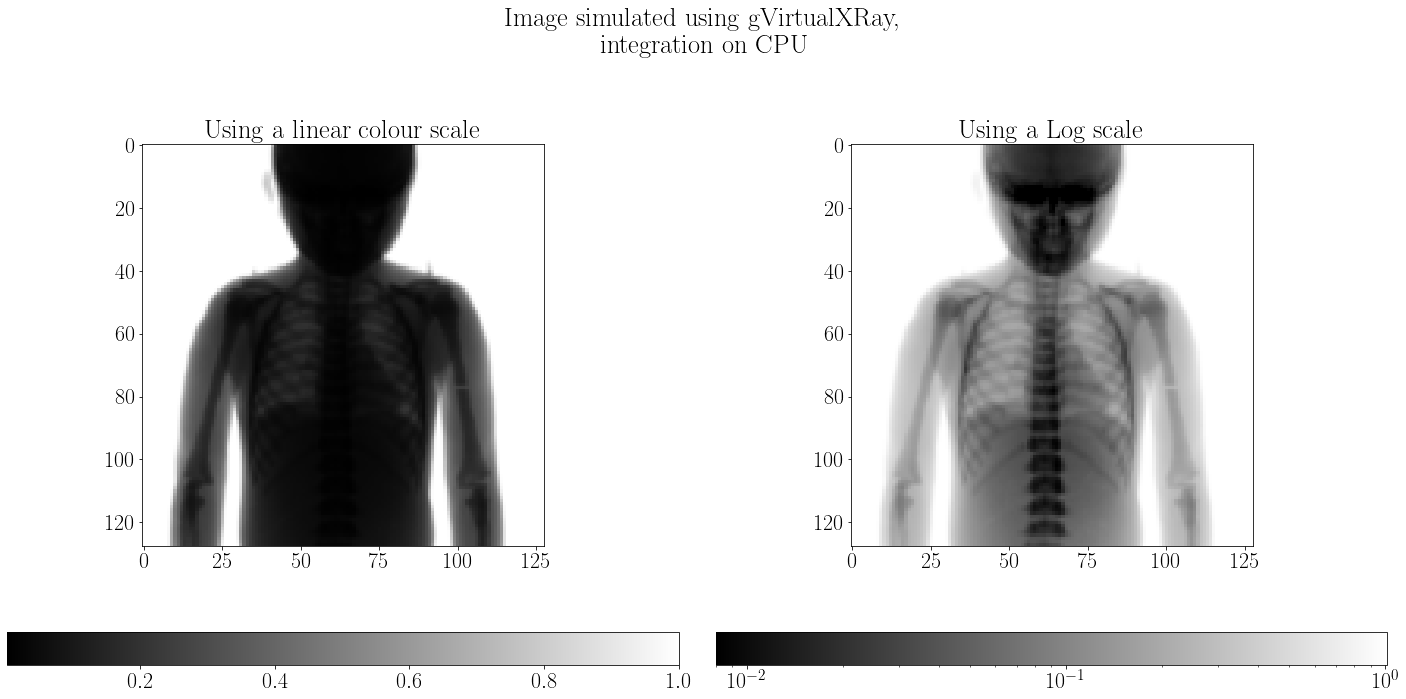

In [26]:
displayLinearPowerScales(x_ray_image_integration_CPU,
                         "Image simulated using gVirtualXRay,\nintegration on CPU",
                         'plots/pediatric_x_ray_image_integration_CPU-detResponse',
                         True, vmin, vmax)

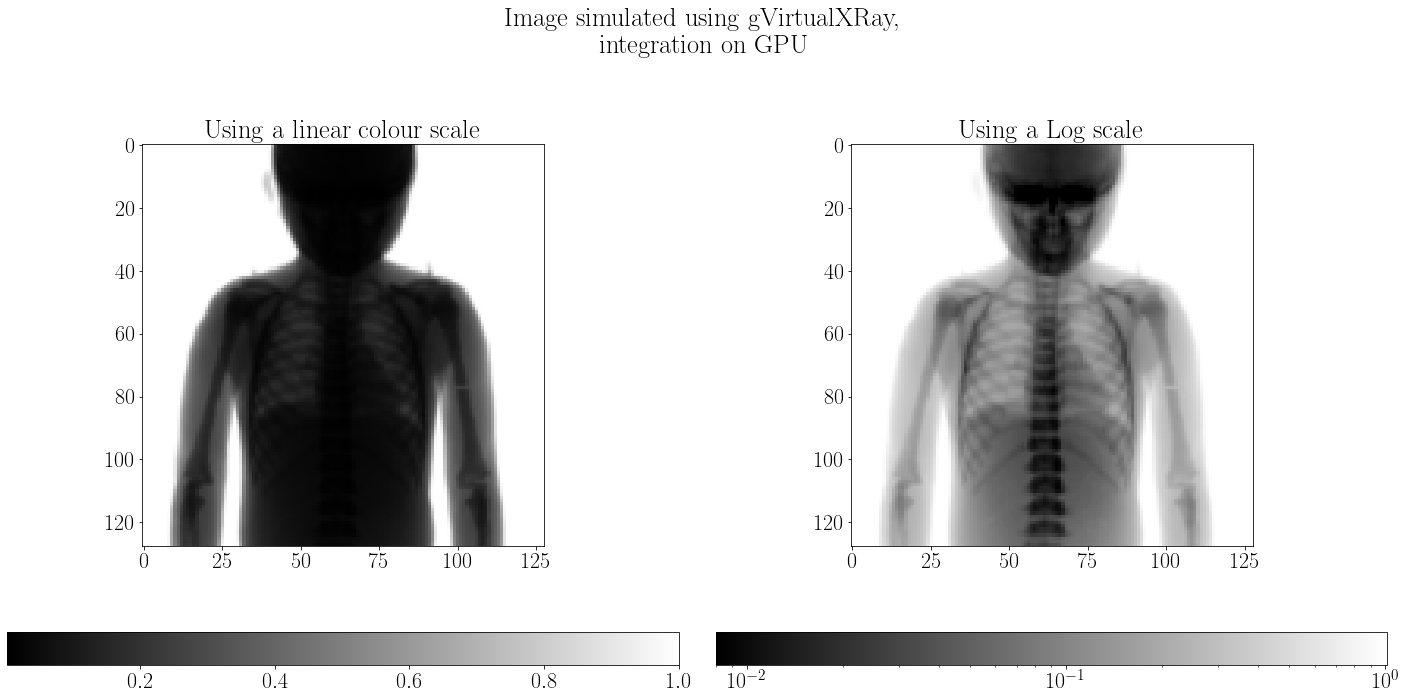

In [27]:
displayLinearPowerScales(x_ray_image_integration_CPU,
                         "Image simulated using gVirtualXRay,\nintegration on GPU",
                         'plots/pediatric_x_ray_image_integration_GPU-detResponse',
                         True, vmin, vmax)

Compare the manual implementation with gvxr's

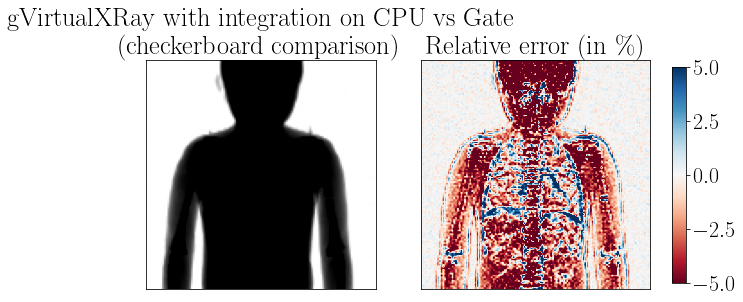

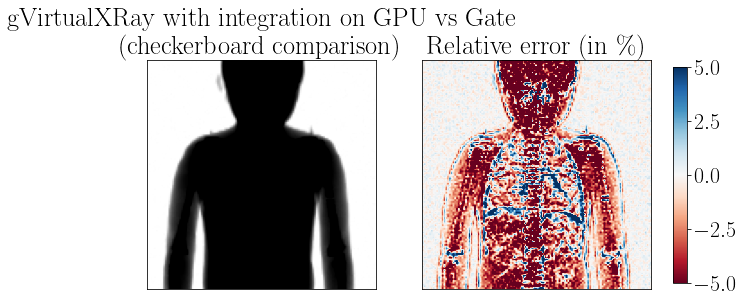

In [28]:
compareImages(x_ray_image_integration_CPU, gate_image,
              "gVirtualXRay with integration on CPU vs Gate\n(checkerboard comparison)",
              'plots/pediatric_comparison_integration_CPU-detResponse',
              threshold=5)

compareImages(x_ray_image_integration_GPU, gate_image,
              "gVirtualXRay with integration on GPU vs Gate\n(checkerboard comparison)",
              'plots/pediatric_comparison_integration_GPU-detResponse',
              threshold=5)

## Comparison the analytic simulation with the Monte Carlo simulation

### Quantitative validation

Compute image metrics between the two simulated images:

1. [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD),
2. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)), and
3. [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity). 


We use these three metrics as one is a disimilarity measurement (MAPE), two are similarity measurement (ZNCC & SSIM). MAPE and ZNCC can be expressed as a percentage, which eases the interpretation of the numerical values. SSIM is a number between 0 and 1. A good value of MAPE s 0%; of ZNCC 100%, and SSIM 1.

In [29]:
# Delete the first row
gate_image = np.delete(gate_image, (0), axis=0)
x_ray_image_integration_CPU = np.delete(x_ray_image_integration_CPU, (0), axis=0)
x_ray_image_integration_GPU = np.delete(x_ray_image_integration_GPU, (0), axis=0)

In [30]:
MAPE_integration_CPU = mape(gate_image, x_ray_image_integration_CPU) # We add offest to avoid a division by zero
ZNCC_integration_CPU = np.mean((gate_image - gate_image.mean()) / gate_image.std() * (x_ray_image_integration_CPU - x_ray_image_integration_CPU.mean()) / x_ray_image_integration_CPU.std())
SSIM_integration_CPU = ssim(gate_image, x_ray_image_integration_CPU, data_range=gate_image.max() - gate_image.min())


print("MAPE_integration_CPU:", "{0:0.2f}".format(100 * MAPE_integration_CPU) + "%")
print("ZNCC_integration_CPU:", "{0:0.2f}".format(100 * ZNCC_integration_CPU) + "%")
print("SSIM_integration_CPU:", "{0:0.2f}".format(SSIM_integration_CPU))

MAPE_integration_GPU = mape(gate_image, x_ray_image_integration_GPU) # We add offest to avoid a division by zero
ZNCC_integration_GPU = np.mean((gate_image - gate_image.mean()) / gate_image.std() * (x_ray_image_integration_GPU - x_ray_image_integration_GPU.mean()) / x_ray_image_integration_GPU.std())
SSIM_integration_GPU = ssim(gate_image, x_ray_image_integration_GPU, data_range=gate_image.max() - gate_image.min())

print("MAPE_integration_GPU:", "{0:0.2f}".format(100 * MAPE_integration_GPU) + "%")
print("ZNCC_integration_GPU:", "{0:0.2f}".format(100 * ZNCC_integration_GPU) + "%")
print("SSIM_integration_GPU:", "{0:0.2f}".format(SSIM_integration_GPU))

MAPE_integration_CPU: 2.49%
ZNCC_integration_CPU: 99.99%
SSIM_integration_CPU: 0.99
MAPE_integration_GPU: 2.47%
ZNCC_integration_GPU: 99.99%
SSIM_integration_GPU: 0.99


In both cases, MAPE is relatively small (less than 5%), the ZNCC and SSIM are very high (99.99% and 0.99 respectively). We can conclude that the two images are similar. The main difference lie in the Poisson noise affecting the Monte Carlo simulation and in suttle differences in the geometrical properties of the scanned object.

### Qualitative validation

Checkboard comparison

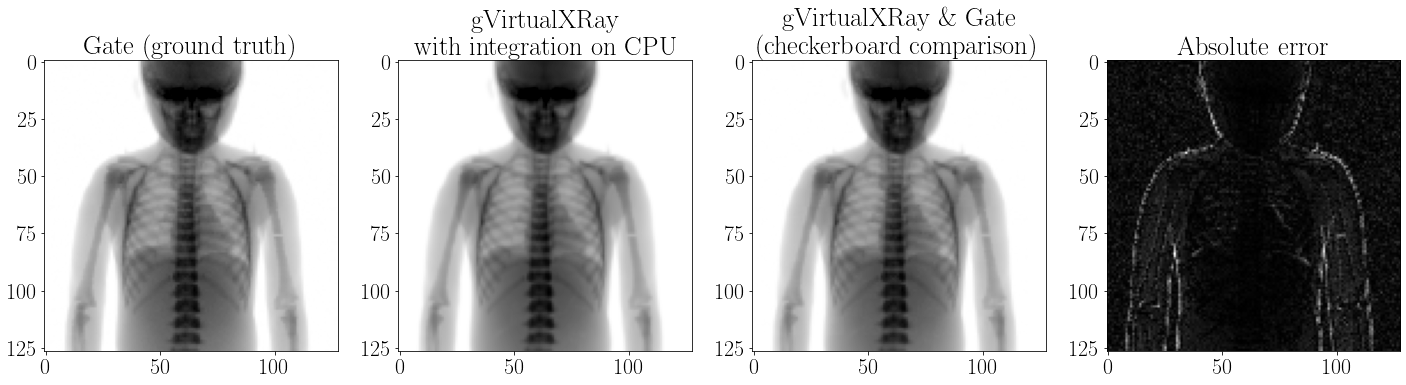

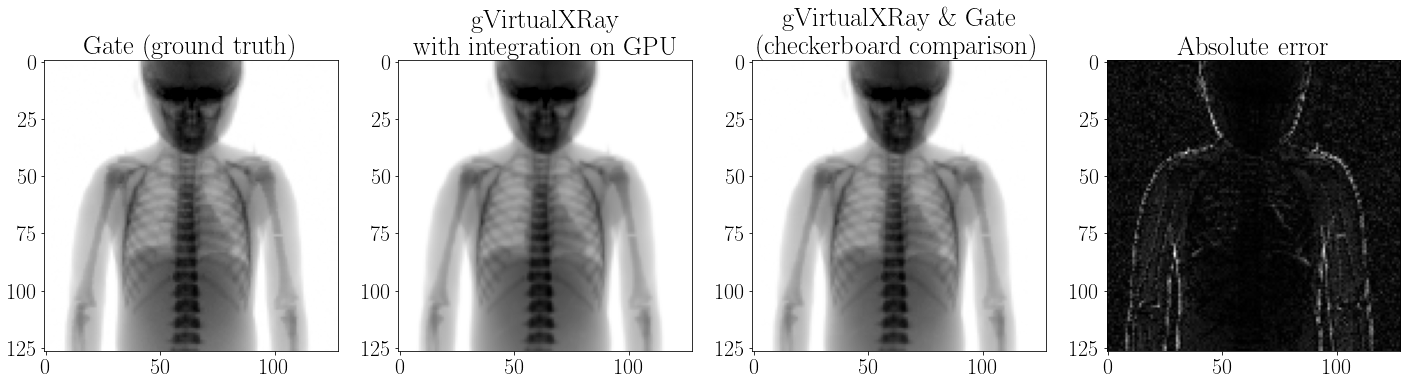

In [31]:
fullCompareImages(gate_image,
                  x_ray_image_integration_CPU,
                  "gVirtualXRay\n with integration on CPU",
                  "plots/pediatric_full_comparison_integration_CPU-detResponse", True, vmin, vmax)

fullCompareImages(gate_image,
                  x_ray_image_integration_GPU,
                  "gVirtualXRay\n with integration on GPU",
                  "plots/pediatric_full_comparison_integration_GPU-detResponse", True, vmin, vmax)

In [32]:
font = {'size'   : 12
       }
matplotlib.rc('font', **font)

Plot the profiles

In [33]:
font = {'size'   : 22
       }
matplotlib.rc('font', **font)

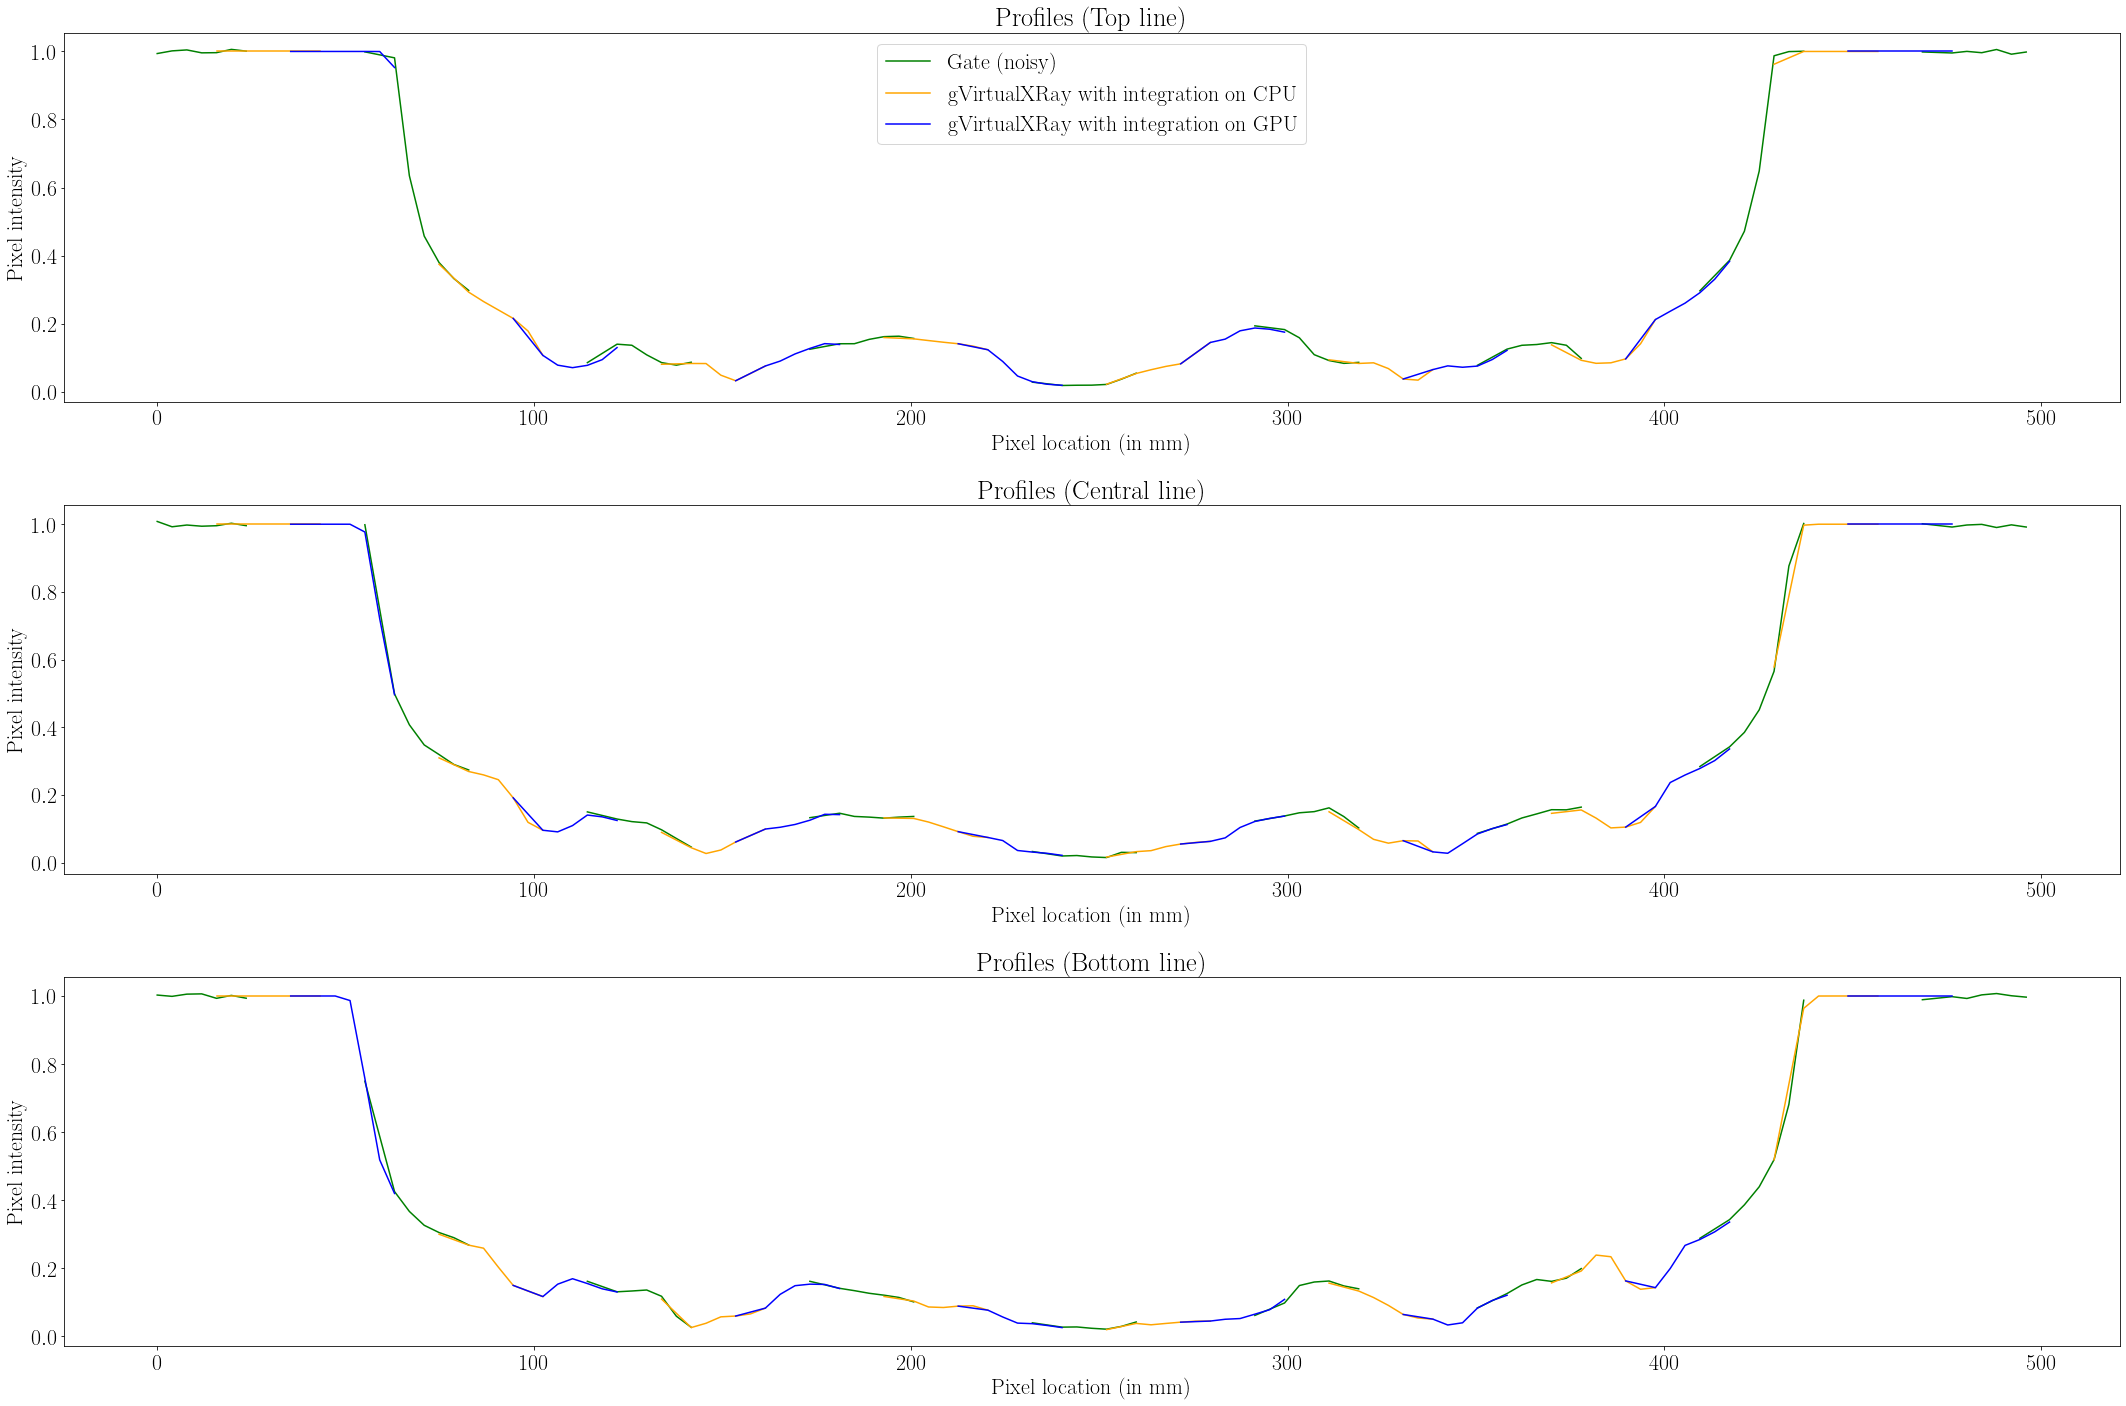

In [34]:
plotProfiles(json2gvxr, gate_image, x_ray_image_integration_CPU, x_ray_image_integration_GPU, "plots/pediatric_profiles-checkerboard-detResponse")

## All done

Destroy the window

In [35]:
gvxr.destroyAllWindows()

gvxrStatus:	Destroy all the windows
gvxrStatus:	Destroy window 0(0x55dc4017bcd0)
